In [ ]:
import torch.nn as nn
import torch.nn.utils
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import numpy as np
import pandas as pd
import random
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

print(f'GPU available: {torch.cuda.is_available()}')

Wed Dec  8 01:07:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#%% read the data (this is the way to read the input column as list of strings)
train = pd.read_csv("complaints_train.csv", converters={"input": lambda x: x.strip("[]").replace("'","").split(", ")})
test = pd.read_csv("complaints_test.csv", converters={"input": lambda x: x.strip("[]").replace("'","").split(", ")})
print(train.head(5))
print(test.head(5))

                                               input  label
0  [began, charg, addit, per, month, call, even, ...      6
1  [file, document, inaccurate, unknown, account,...      3
2  [request, document, bureau, file, contain, wet...      3
3  [account, longer, active, remov, credit, repor...      3
4  [due, job, loss, husband, unable, pay, credit,...      3
                                               input  label
0  [sent, letter, day, ago, request, incorrect, i...      3
1  [ny, social, secur, dob, herebi, make, ghostle...      4
2  [contract, longer, able, view, account, online...      4
3  [repeat, call, compani, say, tri, collect, deb...      4
4  [move, tri, change, internet, new, address, to...      4


In [ ]:
#%% build word count
sentences_train = train["input"].tolist()
sentences_test = test["input"].tolist()
labels_train = train["label"].tolist()
labels_test = test["label"].tolist()

In [ ]:
def shorten_word_list(sentences, max_len):
    shortened_sentences = []
    for sentence in sentences:
        if max_len >= len(sentence):
            shortened_sentences.append(sentence)
        else:
            shortened_sentences.append(sentence[:max_len])
    return shortened_sentences

In [ ]:
from collections import Counter
wordCounts = Counter([w for l in sentences_train for w in l])
print(wordCounts)
print(len(wordCounts))
singletons = set([w for (w,c) in wordCounts.items() if c == 1])
print(singletons)
print(len(singletons))

def find_max_min_avg_list(lst):
    lst_len = [len(i) for i in lst]
    print(max(lst_len))
    print(min(lst_len))
    print(sum(lst_len)/len(lst_len))

print(find_max_min_avg_list(sentences_train))

Counter({'account': 264717, 'credit': 261727, 'report': 261158, 'inform': 125795, 'payment': 100916, 'call': 88215, 'debt': 75123, 'day': 73036, 'time': 71553, 'compani': 67551, 'receiv': 65986, 'consum': 63910, 'bank': 63686, 'letter': 62864, 'request': 61948, 'would': 61069, 'loan': 58992, 'card': 56850, 'sent': 56450, 'collect': 56150, 'state': 53497, 'file': 52477, 'also': 48679, 'dispute': 48383, 'never': 47133, 'told': 46650, 'get': 46649, 'contact': 45185, 'bureau': 44683, 'number': 44256, 'date': 43812, 'ask': 42068, 'back': 40784, 'due': 39614, 'please': 38473, 'month': 37525, 'pay': 37108, 'ident': 37106, 'document': 36936, 'one': 36904, 'agenc': 36298, 'amount': 35928, 'close': 35847, 'balance': 35552, 'need': 35439, 'use': 35266, 'check': 35239, 'item': 34982, 'inquiri': 34601, 'money': 34174, 'still': 33650, 'open': 33418, 'paid': 32932, 'theft': 32878, 'violat': 32846, 'made': 32786, 'person': 32418, 'name': 31871, 'late': 31871, 'email': 31847, 'remov': 31779, 'said': 31

In [ ]:
sentences_train = shorten_word_list(sentences_train, max_len = 300)
print(find_max_min_avg_list(sentences_train))

300
1
73.96948751567666
None


In [ ]:
#%% map word to index
word2i = {w:i+2 for i,w in enumerate(set([w for l in sentences_train for w in l]))}
i2word = {i:w for w,i in word2i.items()}

#When training, randomly replace singletons with UNK tokens sometimes to simulate situation at test time.
def getDictionaryRandomUnk(w, dictionary, train = False):
  if train and (w in singletons and random.random() > 0.5):
    return 1
  else:
    return dictionary.get(w, 1)

#Map a list of sentences from words to indices.
def sentences2indices(words, dictionary, train=False):
  return [[getDictionaryRandomUnk(w,dictionary, train=train) for w in l] for l in words]

In [ ]:
def prepare_input(X_list): # input: list
    X_padded = torch.nn.utils.rnn.pad_sequence([torch.as_tensor(l) for l in X_list], batch_first=True).type(torch.LongTensor)
    X_mask   = torch.nn.utils.rnn.pad_sequence([torch.as_tensor([1.0] * len(l)) for l in X_list], batch_first=True).type(torch.FloatTensor)
    return (X_padded, X_mask)

def prepare_label(Y_list): # input: list
    label = torch.from_numpy(np.array((Y_list)))
    return torch.autograd.Variable(label).long()

In [ ]:
def read_glove(glove_fn):
    GloVe = {}
    for line in open(glove_fn, encoding = "utf-8").readlines():
        fields = line.strip().split(" ")
        word = fields[0]
        GloVe[word] = [float(x) for x in fields[1:]]
    return GloVe

def shuffle_sentences(sentences, tags):
    shuffled_sentences = []
    shuffled_tags      = []
    indices = list(range(len(sentences)))
    random.shuffle(indices)
    for i in indices:
        shuffled_sentences.append(sentences[i])
        shuffled_tags.append(tags[i])
    return (shuffled_sentences, shuffled_tags)

In [ ]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip 
#!unzip -q glove.6B.zip 
glove_fn = "glove.6B.300d.txt"
GloVe = read_glove(glove_fn)

In [ ]:
class BiLSTM(nn.Module):
    def __init__(self, word2i, i2word, dropout, DIM_EMB = 100, DIM_HID = 64, NUM_CLASSES = 7):
        super(BiLSTM, self).__init__()
        self.drop_prob = dropout
        self.VOCAB_SIZE = max(word2i.values()) + 2
        self.DIM_EMB = DIM_EMB
        self.DIM_HID = DIM_HID
        self.output_size = NUM_CLASSES
        self.word2i = word2i
        self.i2word = i2word
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.DIM_EMB)
        self.glove_embed = self.init_glove(GloVe)
        self.embedding = self.embedding.from_pretrained(torch.FloatTensor(self.glove_embed)).to('cuda')
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(self.DIM_EMB, self.DIM_HID, bidirectional = True, batch_first = True)
        self.linear = nn.Linear(self.DIM_HID * 4, 64)
        self.dropout = nn.Dropout(self.drop_prob)
        self.fc_out = nn.Linear(64, self.output_size)

    def init_glove(self, GloVe):
        id2emb = {}
        for ix in range(0, len(self.word2i) + 2):
            try:
                id2emb[ix] = GloVe[self.i2word[ix]]
            except KeyError:
                id2emb[ix] = list(np.random.normal(scale = 0.6, size = (self.DIM_EMB, )))
                #id2emb[ix] = [0.00] * self.DIM_EMB
        numpy_embed = [id2emb[ix] for ix in range(0, len(self.word2i)+2)]
        return numpy_embed

    def forward(self, X, X_mask):
        assert self.VOCAB_SIZE >= X.max()
        embed = self.embedding(X)
        seq_len = [int(X_mask[k].sum().item()) for k in range(len(X))]
        max_seq_len = embed.shape[1]
        embed_packed = pack_padded_sequence(embed, seq_len, batch_first=True, enforce_sorted=False)
        lstm_packed, _ = self.lstm(embed_packed)
        lstm_padded, _ = pad_packed_sequence(lstm_packed, total_length = max_seq_len, batch_first=True)
        avg_pool = torch.mean(lstm_padded, axis = 1)
        max_pool, _ = torch.max(lstm_padded, axis = 1)
        pool = torch.cat((avg_pool, max_pool), axis = 1)
        linear = F.relu(self.linear(pool))
        dropout = self.dropout(linear)
        fc_out = self.fc_out(dropout)
        out = F.log_softmax(fc_out, dim = 1)
        return out

In [ ]:
def train_model(sentences, labels, model, max_len = 300):
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 0.01)
    batchSize = 128
    total_train_loss = 0
    total_train_numcorrect = 0
    sentences = shorten_word_list(sentences, max_len = max_len)
    if torch.cuda.is_available():
        model.cuda()
    model.train()
    for batch in tqdm.notebook.tqdm(range(0, len(sentences), batchSize), leave = False):
        X = sentences2indices(sentences[batch:batch + batchSize], word2i, train = True)
        X_padded = prepare_input(X)[0]
        X_mask = prepare_input(X)[1]
        Y = prepare_label(labels[batch:batch + batchSize])
        if torch.cuda.is_available():
            X_padded = X_padded.cuda()
            Y = Y.cuda()
        model.zero_grad()
        pred = model(X_padded, X_mask)
        loss = F.cross_entropy(pred, Y)
        num_corrects = sum(pred.argmax(axis = 1) == Y)
        total_train_loss += loss.item()
        total_train_numcorrect += num_corrects.item()
        loss.backward()
        optimizer.step()
    return total_train_loss/len(sentences), total_train_numcorrect/len(sentences)

In [ ]:
def eval_model(sentences, labels, model, num_class, max_len = 300):
    total_val_loss = 0
    total_val_numcorrect = 0
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    batchSize = 128
    sentences = shorten_word_list(sentences, max_len)
    val_preds = np.zeros((len(sentences), num_class))
    with torch.no_grad():
        for batch in tqdm.notebook.tqdm(range(0, len(sentences), batchSize), leave = False):
            X = sentences2indices(sentences[batch:batch + batchSize], word2i, train = False)
            X_padded = prepare_input(X)[0]
            X_mask = prepare_input(X)[1]
            Y = prepare_label(labels[batch:batch + batchSize])
            if torch.cuda.is_available():
                X_padded = X_padded.cuda()
                Y = Y.cuda()
                model = model.cuda()
            pred = model(X_padded, X_mask)
            loss = F.cross_entropy(pred, Y)
            num_corrects = sum(pred.argmax(axis = 1) == Y)
            total_val_loss += loss.item()
            total_val_numcorrect += num_corrects.item()
            val_preds[batch : batch + batchSize] = (pred).cpu().numpy()
    return total_val_loss/len(sentences), total_val_numcorrect/len(sentences), val_preds

In [ ]:
def plot_epoch_loss(epochs, train_loss, val_loss):
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label = 'train')
    plt.plot(list(np.arange(epochs) + 1), val_loss, label = 'validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
    plt.show()

def plot_confusion_matrix(true_label, pred_val, ticklabels):
    pred_label = list(pred_val.argmax(axis = 1))
    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(true_label, pred_label)
    sns.heatmap(cm, annot = True, cbar = False,
                fmt = '1d', cmap = 'Blues', ax = ax, annot_kws={"size": 20},
                xticklabels = ticklabels, yticklabels = ticklabels)
    plt.xticks(weight = 'bold', rotation = 90)
    plt.yticks(weight = 'bold')
    ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
    ax.set_xlabel('Predicted Class', fontsize = 24)
    ax.set_ylabel('Actual News Class', fontsize = 24)
    plt.show()
    print("The F1 score of validation set is {}". format(f1_score(true_label, pred_label, average='weighted')))

In [ ]:
model = BiLSTM(word2i, i2word, dropout = 0, DIM_EMB = 300)
nEpoch = 5

In [ ]:
print(model)

BiLSTM(
  (embedding): Embedding(49794, 300)
  (lstm): LSTM(300, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=256, out_features=64, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (fc_out): Linear(in_features=64, out_features=7, bias=True)
)


In [ ]:
train_loss_lst = []
val_loss_lst = []
for epoch in range(nEpoch):
    (sentences_shuffled, labels_shuffled) = shuffle_sentences(sentences_train, labels_train)
    train_loss, train_acc = train_model(sentences_shuffled, labels_shuffled, model)
    val_loss, val_acc, val_preds = eval_model(sentences_test, labels_test, model, num_class = 7)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.4f}, Val. Loss: {val_loss:3f}, Val. Acc: {val_acc:.4f}')
    train_loss_lst.append(train_loss)
    val_loss_lst.append(val_loss)

  0%|          | 0/1097 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

Epoch: 01, Train Loss: 0.004, Train Acc: 0.8156, Val. Loss: 0.003712, Val. Acc: 0.8367


  0%|          | 0/1097 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

Epoch: 02, Train Loss: 0.003, Train Acc: 0.8545, Val. Loss: 0.003408, Val. Acc: 0.8502


  0%|          | 0/1097 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

Epoch: 03, Train Loss: 0.003, Train Acc: 0.8639, Val. Loss: 0.003490, Val. Acc: 0.8499


  0%|          | 0/1097 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

Epoch: 04, Train Loss: 0.003, Train Acc: 0.8703, Val. Loss: 0.003383, Val. Acc: 0.8559


  0%|          | 0/1097 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

Epoch: 05, Train Loss: 0.003, Train Acc: 0.8757, Val. Loss: 0.003434, Val. Acc: 0.8552


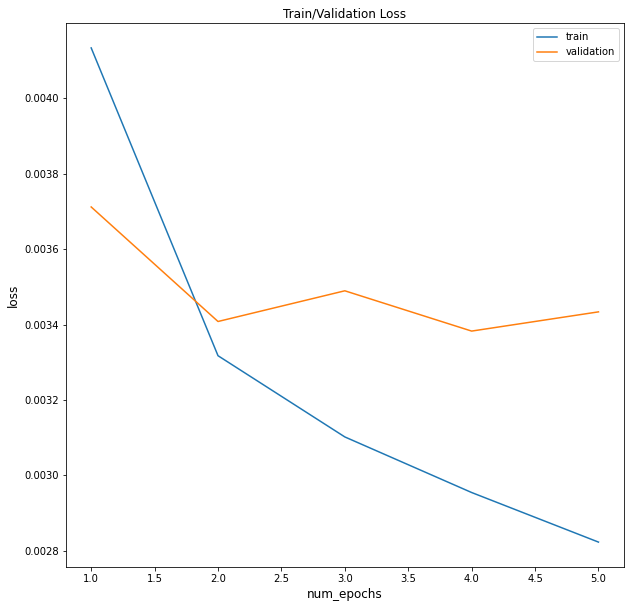

In [ ]:
plot_epoch_loss(nEpoch, train_loss_lst, val_loss_lst)

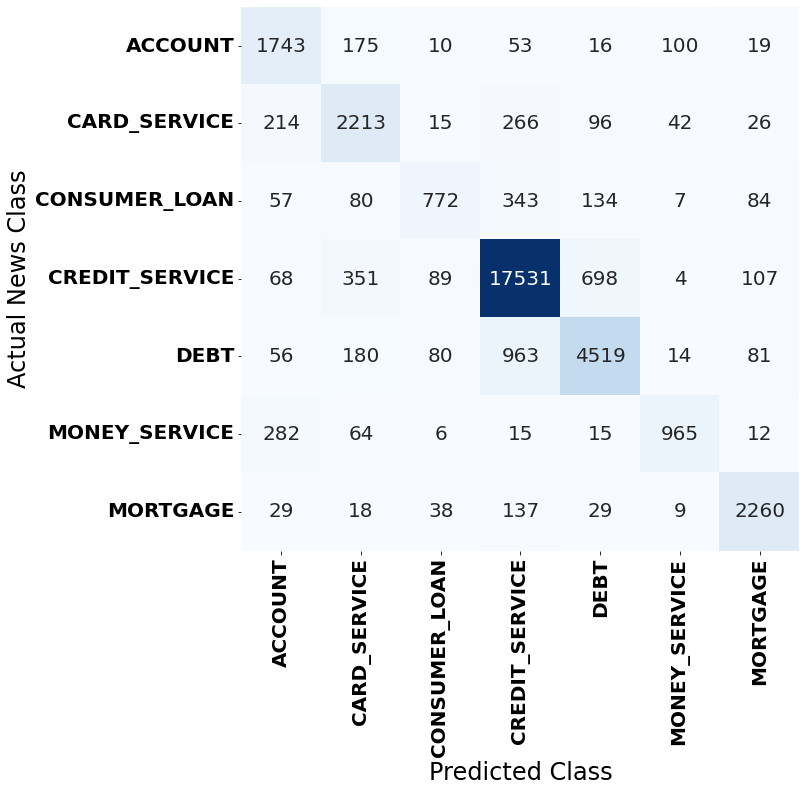

The F1 score of validation set is 0.8533108338170402


In [ ]:
ticklabels = pd.read_csv("encoding_label_dict_token.csv", names = ["name", "label"], header = 0)
ticklabels = ticklabels["name"].tolist()

plot_confusion_matrix(labels_test, val_preds, ticklabels)